In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from keras.models import Sequential, Model
from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, GRU, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU
from tensorflow.keras.losses import Loss
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from poly_interpolation import PolyInter
from sklearn.ensemble import RandomForestRegressor
from macd import Ema    
from keras import backend as K

# df = yf.Ticker('XOM').history(period="max", interval='1wk')
# # df['Close_dif'] = df['Close'].diff()
# df = df.dropna().iloc[:, :4]
# for i in df.columns: df = df[df[i] != 0]

def matrix_2d(x: np.array, timestemp: int) -> list:
    x = deepcopy(x)
    reshaped_x = []
    for i in range(timestemp, x.shape[0] + 1):
        reshaped_x.append(np.array([i[0] for i in x[i - timestemp:i]]))
    return np.array(reshaped_x)

In [55]:
df = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data_scaler/df.csv')
df = df.set_index('Date')
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data_scaler/target.csv')
# df['target_1'] = target['Close'].values
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_2/data_scaler/target.csv')
# df['target_2'] = target['Close_Ema_5_diff'].values
# df = df.iloc[:-1, :]
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_3/data_scaler/target.csv')
# df['target_3'] = target['Close_Ema_5_diff'].values
# df = df.iloc[:-1, :]
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_4/data_scaler/target.csv')
# df['target_4'] = target['Close_Ema_5_diff'].values
# df.head(3)

# ax = df.corr()['target_1'].sort_values()
# df.loc[:, ['target_1', 'Close_Ema_9_diff', 'Close_Ema_5_diff', 'trend_macd_diff']].corr()

Interpolation progress: 100.00%
Interpolation progress: 0.22%

/home/magico/Main/Projects/market-data-pipe/notebooks/poly_interpolation.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pred_inter)


Interpolation progress: 100.00%


/home/magico/Main/Projects/market-data-pipe/notebooks/poly_interpolation.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pred_inter)


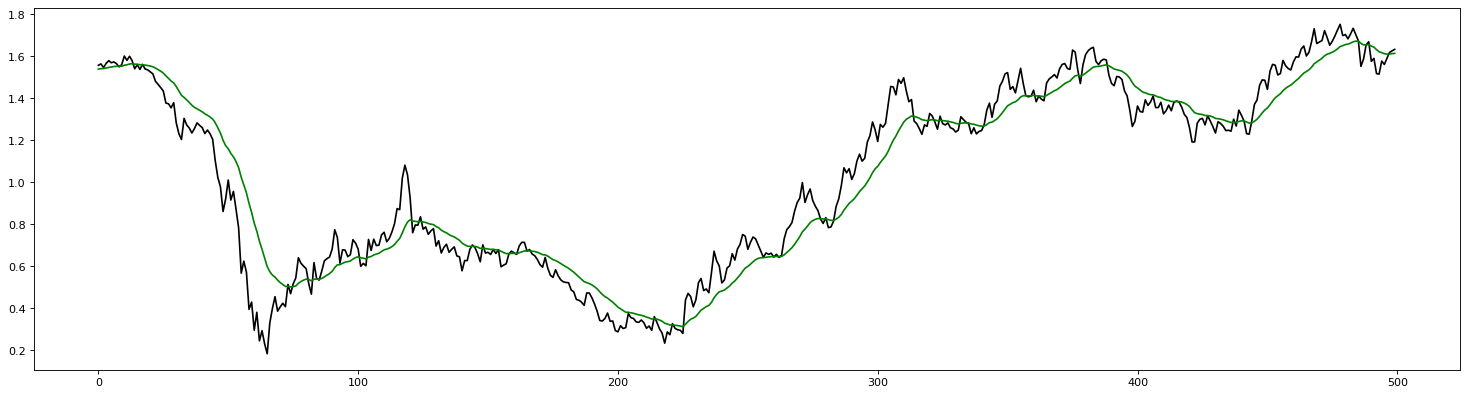

In [57]:
size = -500
x = df.loc[:, ['Close']].reset_index(drop='index').values
poly = PolyInter(x, {"degree":4, "pd":20, "plot":False, "progress_bar":True}).get_values()
ema_21 = Ema(x, {"period":21}).get_values()
poly_ema = PolyInter(ema_21, {"degree":4, "pd":20, "plot":False, "progress_bar":True}).get_values()

figure(figsize=(23, 6), dpi=80)
# plt.plot(poly)
plt.plot(x[size:], color='black')
# plt.plot(np.diff(df['Close'].values[size - 1:]), color='red')
plt.plot(ema_21[size:], color='green')
# plt.plot(poly_ema, color='brown')
df['ema'] = ema_21

/home/magico/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/magico/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


R2   0.8722528442940229
MSE  0.008554336420022231
MAPE 0.0628735881806493


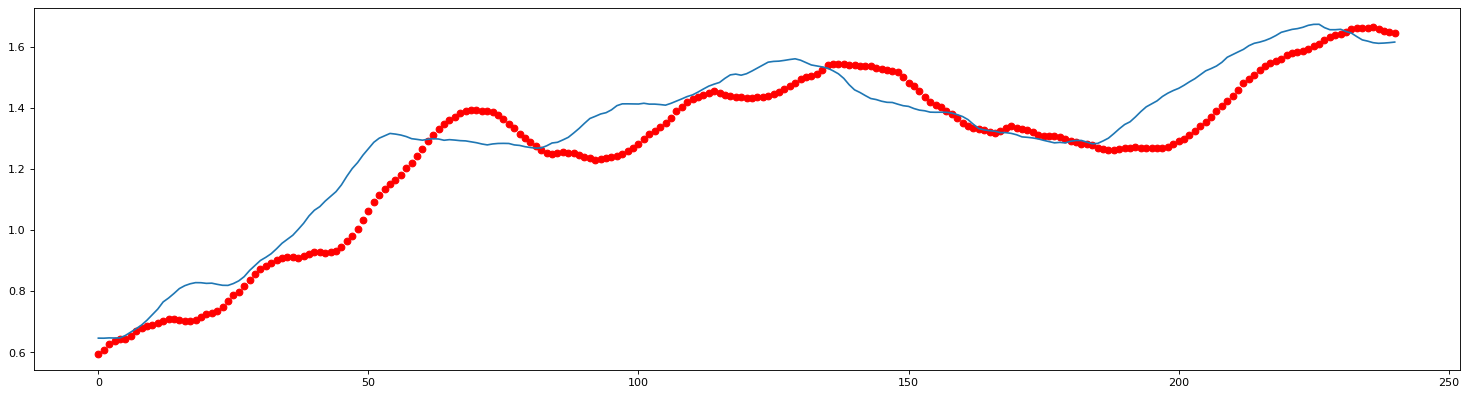

In [98]:
def regressor(tah):
    X =  df.loc[:, ['ema']].reset_index(drop='index').values[:-tah]
    y =  df.loc[:, ['ema']].reset_index(drop='index').values[tah:]

    x_2d = matrix_2d(X[:-300], 60)
    y_ax = y[:-300][59:]

    X_train, x_test, y_train, y_test = train_test_split(x_2d, y_ax, test_size=0.33, random_state=42)

    # model = KNeighborsRegressor(n_neighbors=2)
    model = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
    # print(regr.score(x_test, y_test))
    model.fit(X_train, y_train)

    x_2d = matrix_2d(X[-300:], 60)
    y_ax = y[-300:][59:]

    pred = model.predict(x_2d)

    print(f'R2   {model.score(x_2d, y_ax)}')
    print(f'MSE  {mean_squared_error(pred, y_ax)}')
    print(f'MAPE {mean_absolute_percentage_error(pred, y_ax)}')
    figure(figsize=(23, 6), dpi=80)
    plt.plot(y_ax)
    plt.scatter(range(y_ax.shape[0]), pred, color='red')
    plt.show()


regressor(10)
# regressor(2)
# regressor(3)
# regressor(4)

In [89]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def regression(X, y) -> None:
        size = -300
        x_train, x_test, y_train, y_test = train_test_split(X[:size], y[:size], test_size=0.33, random_state=42)

        model = Sequential()

        model.add(LSTM(300, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.20))

        model.add(LSTM(300, return_sequences=False, activation='tanh'))
        model.add(Dropout(0.20))

        model.add(Dense(100, activation='tanh'))
        model.add(Dense(100, activation='tanh'))
        model.add(Dense(100, activation='tanh'))
        model.add(Dense(100, activation='tanh'))
        model.add(Dense(1))

        model.compile(loss='mse', optimizer=Adam(learning_rate=0.005), metrics=[coeff_determination])
        model.fit(x_train, y_train, epochs=1, batch_size=1200, shuffle=True, validation_data=(x_test, y_test), verbose=1)

        pred = model.predict(X[size:])
        print(f'R2   {r2_score(pred, y[size:])}')
        print(f'MSE  {mean_squared_error(pred, y[size:])}')
        print(f'MAPE {mean_absolute_percentage_error(pred, y[size:])}')
        figure(figsize=(23, 6), dpi=80)
        plt.plot(y[size:])
        plt.scatter(range(y[size:].shape[0]), pred, color='red')
        plt.show()



X =  df.loc[:, ['ema']].reset_index(drop='index').values[:-1]
y =  df.loc[:, ['ema']].reset_index(drop='index').values[1:]

def matrix_3d(x: np.array, timestemp: int) -> list:
    x = deepcopy(x)
    reshaped_x = []
    for i in range(timestemp, x.shape[0] + 1):
        reshaped_x.append(x[i - timestemp:i])
    return np.array(reshaped_x)


X_3d = matrix_3d(X, 64)
y_ax = y[63:]
# regression(X_3d, y_ax)

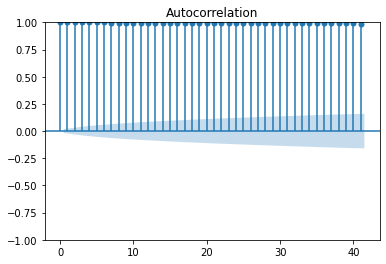

count    12189.000000
mean         0.005482
std          0.998832
min         -0.952451
25%         -0.899321
50%         -0.356608
75%          0.900113
max          2.069914
Name: ema, dtype: float64


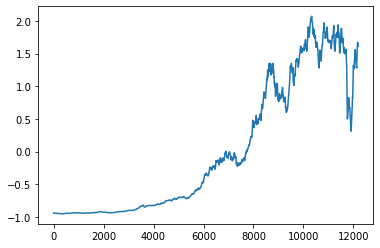

In [80]:
plot_acf(df['ema'])
plt.show()
# print(df.corr()['ema'].sort_values())
print(df['ema'].describe())
# df['ema'].hist()
plt.plot(df['ema'].values)